<h1 align='center'> FEniCS Thermal Transport in TiAl$_2$O$_3$ Cylindrical Geometry </h1>
<center>
Nicholas Goldring <br>
RadiaSoft LLC <br>
April 2022 <br>

***
## Notes
***


model diagram

<img src="figures/crystal_diagram01.PNG">

<!-- $
hse = T_0 + T_1 \left( e^{-\frac{z + l/2}{0.3l}} + e^{\frac{z - l/2}{0.3l}} \right) e^{-\frac{1}{2} {\left(\frac{x^2 + y^2}{w^2} \right)}^{p_x} }
$ -->

<!-- $x, \hspace{1mm} y, \hspace{1mm} z$ : spatial coordinates [cm] \
$T_0$ : temperature input at time = 0s [$^\circ$C] \
$T_1$ : temperature input at time of incident heat load [$^\circ$C] \
$l$ : crystal length [cm] \
$w^2$ : variance [cm$^2$] \
$p_x$ : x-component of Super Gaussian exponent -->

***
$\textbf{Imports and definitions}$
***

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import norm
import time as tm
import copy
import warnings
from IPython.display import Latex

from fenics import*
from mshr import*

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 19, 'weight' : 'bold'}
hfontMed2 = {'fontname':'Cambria', 'size' : 19, 'weight' : 'bold'}


***
$\textbf{Create and mesh geometry}$

In [2]:
# geometry dimensions
leng = 2.5  # cylinder length [cm]
diam = 1.0  # cylinder diameter [cm]

# derived parameters
rad = diam / 2    # radius [cm]
lh = leng / 2     # half-length [cm]
rad2 = rad * rad  # radius squared [cm^2]


# create a cylindrical geometry
# cylinder = Cylinder('coordinate of center of the top circle', 'coordinate of center of the bottom circle', 'radius of the circle at the top', 'radius of the circle at the bottom')
cylinder = Cylinder(Point(0, 0, lh), Point(0, 0, -lh), rad, rad)
geometry = cylinder

# define mesh
mden = 25  # mesh density
mesh = generate_mesh(geometry, mden)

# save the mesh
File("cylinder.pvd") << mesh
print('rad: %s cm' %(rad))

rad: 0.5 cm
Generating mesh with CGAL 3D mesh generator


In [3]:
# plot mesh
print('Geometry')
print('length: %s cm, radius: %s cm' %(leng, rad))
print('Mesh')
print('mesh density: %s, no. of tetrahedral elements: %s, no. of vertices: %s' %(mden, mesh.num_cells(), mesh.num_vertices()))
mesh

Geometry
length: 2.5 cm, radius: 0.5 cm
Mesh
mesh density: 25, no. of tetrahedral elements: 7193, no. of vertices: 1502


***
$\textbf{Define boundary and initial conditions, sources}$

In [10]:
# constants
T0 =  0.0        # deg C : T_0
# dT    = 20.0     # deg C : T_1 - used in earlier heat load expressions
# wdT   = 0.25   # laser radius [cm] (1/2 crystal radius)
wdT = 0.162      # laser radius [cm] - calculated via w_p = sqrt(2) * c_1
# ldT   =  0.40  # cm
# sg_px = 8        # 1 : x-component of super gaussian exponent
# sg_py = 1        # 1 : y-component of super gaussian exponent
# rad_ratio_sq = (rad**2) / (wdT**2)
# log_rrsq = np.log(rad_ratio_sq)
# print('log of square of radius ratio: %s' %(log_rrsq))

# define function space on mesh
V = FunctionSpace(mesh, 'P', 1)

# define Dirichlet boundary condition for sides at r_max
tol = 1.e-13
def boundary_D(x, on_boundary):
    return on_boundary and near(x[0]*x[0] + x[1]*x[1], rad2, tol)
bc = DirichletBC(V, Constant(T0), boundary_D)

# Gaussian (BELLA pump laser)
pix_to_deg = 6.9                  # pix to micron ratio 1 pixel/6.9 micron
# a1 = 3.84e4                     # Gaussian amplitude
b1 = 0.0   # 361.5
c1 = 166.0 * pix_to_deg / 1e4     # variance [cm]
print('variance, c1: %s [cm]' %(c1))

# absorption length inferred from Chenais paper: alpha = ~0.4 1/cm
# absorption length for BELLA pi-polarized pump: 1.2 1/cm  (95.5% absorption)
alpha_h = 1.2           # absorption length [1/cm]

# calculate incremental temperature deposition
PumpPower = 20                                                      # pump laser power [W]
P_abs = PumpPower * (800-532)/800                                   # absorbed power [W]  (previously used 35 * 2 in top hat heat load)
print('Absorbed power: %f [W]' %(P_abs))
# V_abs = np.pi * (wdT/100)**2 * (leng/100)                         # absorption volume [m^3]  (1/100 to convert cm to m)
V_eff = np.pi * c1**2 * (1 - np.exp(-alpha_h * leng)) / alpha_h     # effective volume [cm^3]
K_c_tisaph = 33/100                                                 # thermal conductivity [W/cm/K]    https://www.rp-photonics.com/titanium_sapphire_lasers.html
K_c_ndyag = 0.1                                                     # thermal conductivity of Nd:YAG [W/cm/K]
rho_tisaph = 3.98                                                   # density of Ti:Sapphire [gm/cm^3]
rho_ndyag = 4.56                                                    # density of Nd:YAG [gm/cm^3]
rho = rho_ndyag
c_p_tisaph = 0.756                                                  # specific heat of Ti:Sapphire [J/gm/K]
c_p_ndyag = 0.59                                                    # specific heat of Nd:YAG [J/gm/K]
c_p = c_p_ndyag

# dQ_incr = P_abs / V_abs             # incremental heat deposition [W/m^3]
dQ_incr = P_abs / V_eff               # incremental heat deposition [W/m^3]
dT_incr = dQ_incr / rho / c_p         # incremental temperature deposition [K/s]

print('dQ_incr: %f [W/cm^3], dT_incr: %f [K/s]' %(dQ_incr, dT_incr))

variance, c1: 0.11454 [cm]
Absorbed power: 6.700000 [W]
dQ_incr: 205.291459 [W/cm^3], dT_incr: 76.305181 [K/s]


***
**Define heat load expression**

In [12]:
# define heat load expressions
gsn_bella_heat_load = Expression('dT * exp( -(pow((x[0] - b1) / c1, 2) + pow((x[1] - b1) / c1, 2)) ) * exp(-alpha_h * x[2])',
                                 degree = 1, dT = dT_incr, b1 = b1, c1 = c1, alpha_h = alpha_h)

# # exp(decay) x Super Gaussian
# expsg_heat_load = Expression('T0 + dT * (exp(-(x[2]+l/2)/dl) + exp((x[2]-l/2)/dl)) \
#                     * exp(-0.5 * pow((x[0]*x[0] + x[1]*x[1])/(w*w), px))',
#                  degree=1, T0=T0, dT=dT_incr, w=wdT, l=leng, dl=0.3*leng, px=sg_px)

# uniform top-hat
uniform_heat_load = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)',
                   degree=1, dT=dT_incr, w=wdT)

# z-dependent heat load with abs. length
# long_abs_heat_load = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)*(alpha_h*exp(-alpha_h*x[2]) / (1 - exp(-alpha_h*leng)))',
#                    degree=1, alpha_h=alpha_h, leng=leng, dT=dT_incr, w=wdT)

long_abs_heat_load = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)*(exp(-alpha_h*x[2]))',
                   degree=1, alpha_h=alpha_h, leng=leng, dT=dT_incr, w=wdT)

# # chenais top-hat w/ absorption coefficient term and log term
# chenais_heat_load_logterm = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0) * (exp(-alpha_h*x[2]) / (1 - exp(-alpha_h*leng))) * log_rrsq',
#                    degree=1, alpha_h=alpha_h, leng=leng, dT=dT_incr, log_rrsq=log_rrsq, w=wdT)

#test_cpp_func01 = Expression('(alpha_h*exp(alpha_h) / (1 - exp(alpha_h)))', degree=1, alpha_h=alpha_h, dT=dQ, w=wdT)

# # T0 + dT x Θ(w–r)
# # standard cylinder running length of crystal with given radius
# # Heaviside theta function: 1 everywhere argument is positive, 0 everwhere argument is negative
# # Vary radius (w^2) - rate of decay.  Try double size of w  
# bolus = Expression('T0 + dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)',
#                    degree=1, T0=T0, dT=dT, w=wdT)

# define initial value
# u_n = interpolate(uniform_heat_load, V)
# u_n = interpolate(bolus, V)
# u_n = interpolate(hse, V)
u_n = interpolate(Constant(T0), V)

# tol = 1e-2  # originally set to 1e-2 by Dan
tol = 2e-2
u_min = u_n(rad-tol, 0., 0.)
u_max = u_n(0., 0., lh-tol)
#print(u_min, u_max)
u_n(rad-tol, 0., 0.), u_n(0., 0., lh-tol)
#print(u_min, u_max)

(0.0, 0.0)

In [13]:
# define crystal properties
a_Al2O3 = 7.98e-2  # cm^2/s diffusion constant of sapphire (Al2O3): (thermal conductivity [W/cm/K] / rho [gm/cm^3] / specific heat capacity(J/gm/K))
a_perp  = 7.64e-2  # perpendicular to C
a_para  = 8.57e-2  # parallel to C

a_tisaph = K_c_tisaph / c_p_tisaph / rho_tisaph
a_ndyag = K_c_ndyag / c_p_ndyag / rho_ndyag

a_crystal = a_ndyag

print('a_tisaph: %s [cm^2/s]' %a_tisaph)
print('a_ndyag: %s [cm^2/s]' %a_ndyag)

a_tisaph: 0.10967536093164235 [cm^2/s]
a_ndyag: 0.03716919417187036 [cm^2/s]


***
**Define simulation time stepping**

Variational formulation \
*A straightforward approach to solving time-dependent PDEs by the finite
element method is to first discretize the time derivative by a finite difference
approximation, which yields a sequence of stationary problems, and then turn
each stationary problem into a variational formulation.*

In [14]:


# define time stepping
T = 1.5e1          # total simulation time [s]
n_steps = 1000     # number of time steps
dt = T / n_steps   # size of time step [s]
nip = 20           # number of intervals between records
print('dt: %s s' %dt)

# define variational problem
u = TrialFunction(V)
v = TestFunction(V)

# source term 
f = gsn_bella_heat_load           # Gaussian heat load for BELLA pump laser
# f = Constant(0)                 # no source term
# f = uniform_heat_load           # uniform cylindrical heat load
# f = long_abs_heat_load          # Chenais heat load formula (2.1.6) without log term
# f = chenais_heat_load_logterm   # chenais heat load eqn. 2.1.6 with log term
# f = bolus                       # source term bolus
# f = expsg_heat_load             # source term hse

# F = u*v*dx + dt*a_Al2O3*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx + gi*v*ds  # w/ Neumann BC
F = u*v*dx + dt*a_crystal*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx  # w/ Dirichlet + initial condition
a, L = lhs(F), rhs(F)




# define time-evolution function
def evolve():

    g_src = gsn_bella_heat_load
    
    # report initial state
    yield u_n

    # time-stepping
    u = Function(V)
    t = 0
    for n in range(1, n_steps + 1):

        # update current time
        t += dt
        # print('t_off: %s, t: %s' %(t_off, t))
        
        # uncomment below to switch off pump laser at t = t_off [s]
        # if t_off < t:
        #     g_src.dT = 0.
                 
        # compute solution
        set_log_level(30)
        solve(a == L, u, bc)

        # report current state
        if n % nip == 0:
            yield u

        # update previous solution
        u_n.assign(u)
        
#         # use if else to set source term, f, based on time - shut off laser (set source term to zero) at certain time
#         if t <= t_off:
#             # f = gsn_bella_heat_load
#             g_src = gsn_bella_heat_load
        
#             # compute solution
#             set_log_level(30)
#             solve(a == L, u, bc)

#             # report current state
#             if n % nip == 0:
#                 yield u

#             # update previous solution
#             u_n.assign(u)
        
#         elif t > t_off:
#             # f = Constant(0)
#             g_src.dT = 0.
        
#             # compute solution
#             set_log_level(30)
#             solve(a == L, u, bc)

#             # report current state
#             if n % nip == 0:
#                 yield u

#             # update previous solution
#             u_n.assign(u)
            

dt: 0.015 s


***
$\textbf{Define facets, coordinates for extracting data and plotting}$

In [15]:
# for 3D plots, get the facets, and build an array
# containing the indices of their coordinates
inds = []
for item in dolfin.cpp.mesh.facets(mesh):
    inds.append(item.entities(0).tolist())

# we will provide these indices to plotly so it can draw proper surfaces
inds = np.array(inds)
ii = inds[:, 0]
jj = inds[:, 1]
kk = inds[:, 2]

# get node coördinate values and ranges
xvals = mesh.coordinates()[:,0]
yvals = mesh.coordinates()[:,1]
zvals = mesh.coordinates()[:,2]
xmin, xmax = xvals.min(), xvals.max()
ymin, ymax = yvals.min(), yvals.max()
zmin, zmax = zvals.min(), zvals.max()

***
$\textbf{Execute simulation}$

Calling FFC just-in-time (JIT) compiler, this may take some time.
mesh density: 25, no. of tetrahedral elements: 7193, no. of vertices: 1502
simulation time: 0.607 minutes


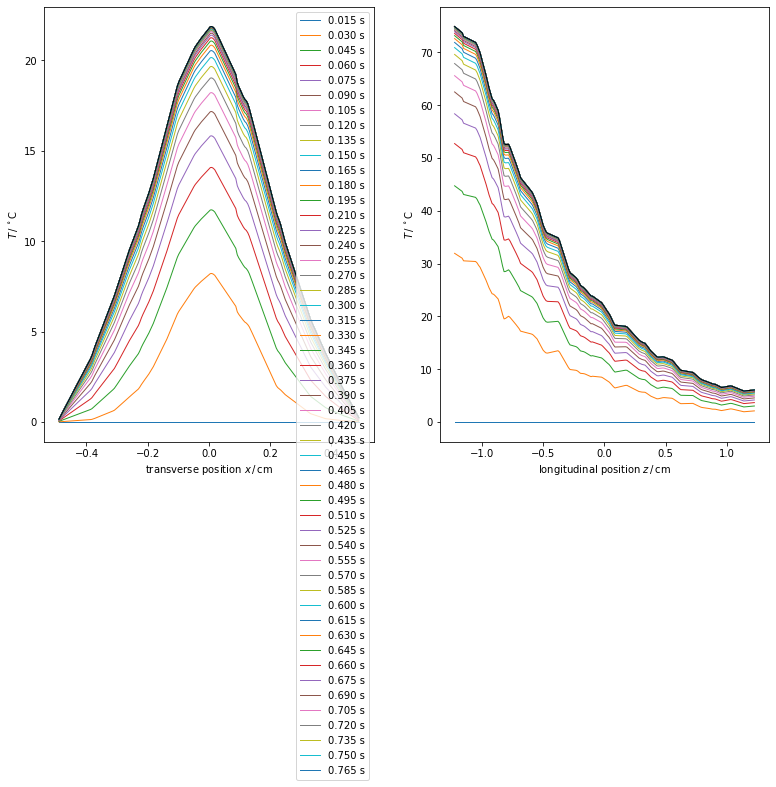

In [16]:
n_rows = 1
n_cols = 2
# fig_wd = 15
# default sizing here yields unit aspect ratio
# plt.figure(figsize = (fig_wd, fig_wd * n_rows // n_cols))
# plt.subplot(n_rows, n_cols, idx)

fig = plt.figure(figsize=(13,8))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

tol = 2.e-2  # avoid points outside domain (for a coarse mesh, increase this value) - already defined above
xv = np.linspace(xmin * (1 - tol), xmax * (1 - tol), 201)
zv = np.linspace(zmin * (1 - tol), zmax * (1 - tol), 201)
radpts = [(x_, 0, 0) for x_ in xv]
axipts = [(0, 0, z_) for z_ in zv]

# define laser shut-off time [s]
t_off = 0.7

idx = 0   # number of time steps to complete simulation, idx*dt will yield final simulation time

T_center = []
T_entrance = []
t_vals = []

t0 = tm.time()
for u in evolve():
    idx += 1
    ux = np.array([u(pt) for pt in radpts])
    uz = np.array([u(pt) for pt in axipts])
    fig1.plot(xv, ux, lw=1, label='{0:5.3f} s'.format(idx*dt))  
    fig2.plot(zv, uz, lw=1)
    T_center.append(u(0, 0, 0))
    T_entrance.append(u(0, 0, zv[0]))
    t_vals.append((idx - 1) * dt)
t1 = tm.time()

fig1.plot(xv, ux, 'k', lw=1)
fig1.legend()
fig2.plot(zv, uz, 'k', lw=1)  
#fig2.legend()

fig1.set_xlabel(r'transverse position $x\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

fig.savefig('heat_decay_profiles.pdf')
fig.show()

print('mesh density: %s, no. of tetrahedral elements: %s, no. of vertices: %s' %(mden, mesh.num_cells(), mesh.num_vertices()))
print("simulation time: %4.3f minutes" % ((t1 - t0)/60.0))
#print("simulation time: %4.3f seconds" % (t1 - t0))

In [17]:
t_off

0.7

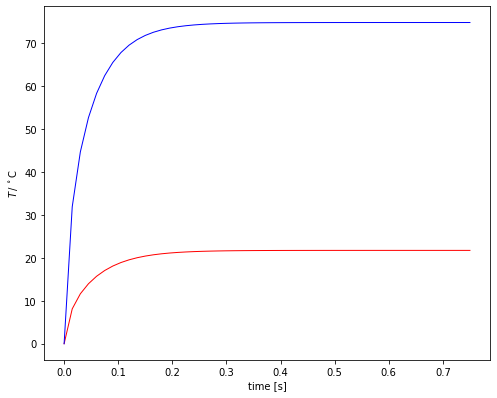

In [18]:
# plot center point temperature profiles at entrance and half-length
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals, T_center,'r-', lw = 1)
ax.plot(t_vals, T_entrance, 'b-', lw = 1)
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig.show()

In [19]:
t_vals

[0.0,
 0.015,
 0.03,
 0.045,
 0.06,
 0.075,
 0.09,
 0.105,
 0.12,
 0.135,
 0.15,
 0.16499999999999998,
 0.18,
 0.195,
 0.21,
 0.22499999999999998,
 0.24,
 0.255,
 0.27,
 0.285,
 0.3,
 0.315,
 0.32999999999999996,
 0.345,
 0.36,
 0.375,
 0.39,
 0.40499999999999997,
 0.42,
 0.435,
 0.44999999999999996,
 0.46499999999999997,
 0.48,
 0.495,
 0.51,
 0.525,
 0.54,
 0.5549999999999999,
 0.57,
 0.585,
 0.6,
 0.615,
 0.63,
 0.645,
 0.6599999999999999,
 0.6749999999999999,
 0.69,
 0.705,
 0.72,
 0.735,
 0.75]

In [20]:
idx

51

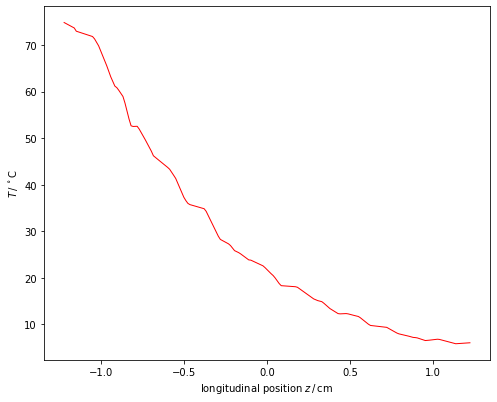

In [21]:
# plot longitudinal temperature profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(zv, uz,'r-', lw = 1)
ax.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig.show()

***
$\textbf{Calculate longitudinal average of transverse temperatures and find quadratic fits for n slices}$

#### 1. Extract longitudinal temp data for range of radii.

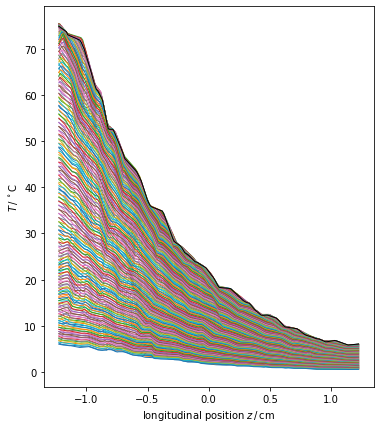

In [22]:
# note:
# throws an error to evaluate at the limits of radpts -
# reduce the value of radpts by some factor, rad_fac
rad_fac = 0.9
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
uz_array = np.zeros((len(radpts), len(zv)))
for j in range(len(radpts)):
    uz_array[j] = [u(pt) for pt in [(radpts[j][0]*rad_fac, 0, z_) for z_ in zv]]
    fig1.plot(zv, uz_array[j], lw=1)
    # fig1.plot(zv, uz_array[j], lw=1, label='{0:5.1f}'.format(radpts[j][0]*.9))
fig1.plot(zv, uz, 'k', lw=1)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
# fig1.legend()
fig.show()

### 2. Divide data into n longitudinal slices.

In [23]:
n_uz = 8                            # no. of longitudinal slices
n_uz_tot = len(radpts) - 1          # total no. of longitudinal profiles in uz_array
print('total no. of longitudinal profiles in uz_array:', n_uz_tot)

# extract only r_x vals from radpts
radpts_array = np.array(radpts)
radpts_x = radpts_array[:,0]
print('shape of radpts_x:', np.shape(radpts_x))

# print(uz_array[:,0:n_uz])
# print('shape of uz_array[0:n_uz,:]:', np.shape(uz_array[0:n_uz,:]))
# print('shape of zv:', np.shape(zv))
# print('shape of zv[0:n_uz]:', np.shape(zv[0:n_uz]))

dslice_ind = int(n_uz_tot/n_uz)                 # size of of slice indeces
print('size of slice indeces, dslice_ind:', dslice_ind)

for i in range(0,5):
    globals()['x'+str(i)] = i
    
    # print(x1)
print(x0)
print(x1)


total no. of longitudinal profiles in uz_array: 200
shape of radpts_x: (201,)
size of slice indeces, dslice_ind: 25
0
1


In [24]:
for j in range(n_uz - 1):
    
    print(j + 1)
    uz_array0 = np.transpose(uz_array[:,0:dslice_ind])
    zv_array0 = zv[0:dslice_ind]
    radpts_x0 = radpts_array[0:dslice_ind,:]  
    
    globals()['uz_array'+str(j + 1)] = np.transpose(uz_array[:,(dslice_ind*(j+1)):(dslice_ind*(j+2))])
    globals()['zv_array'+str(j + 1)] = zv[(dslice_ind*j):(dslice_ind*(j+1))]
    globals()['radpts_x'+str(j + 1)] = radpts_array[(dslice_ind*j):(dslice_ind*(j+1)),:] 


1
2
3
4
5
6
7


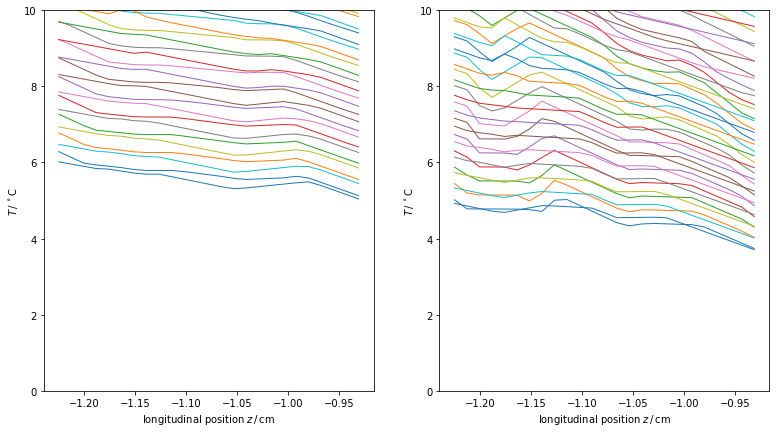

In [25]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(zv_array0, uz_array0, lw=1)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig1.set_ylim(0, 10)


fig2.plot(zv_array1, uz_array1, lw=1)
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_ylim(0, 10)
# fig1.legend()

fig.show()

# print(uz_array[0:n_uz,:])
# print('shape of uz_array[0:n_uz,:]:', np.shape(uz_array[0:n_uz,:]))

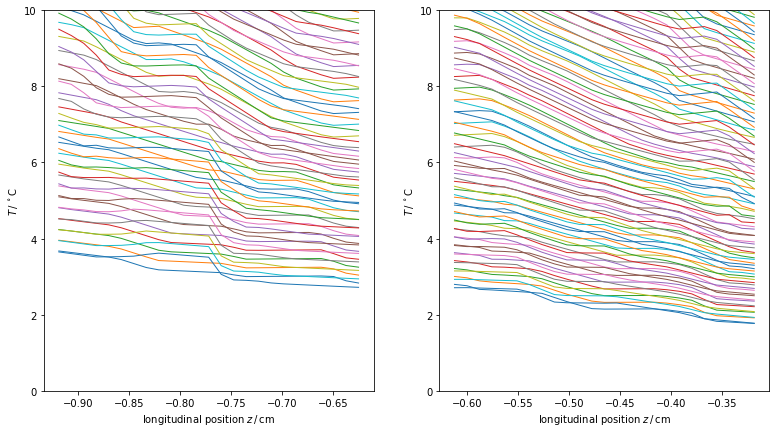

In [26]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(zv_array2, uz_array2, lw=1)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig1.set_ylim(0, 10)


fig2.plot(zv_array3, uz_array3, lw=1)
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_ylim(0, 10)
# fig1.legend()

fig.show()

# print(uz_array[0:n_uz,:])
# print('shape of uz_array[0:n_uz,:]:', np.shape(uz_array[0:n_uz,:]))

### Integrate longitudinal temperature profiles

In [27]:
# calculate longitudinal step size, dz
dz = (zv[len(zv) - 1] - zv[0]) / (len(zv) - 1)
print('dz: %.7s cm' %(dz))

for j in range(n_uz):
    globals()['t_int_vals'+str(j)] = []
    # print(j)
    for i in range((len(radpts_x) - 0)):
    # print('j + 1:', j + 1)
    
        globals()['t_int'+str(j)] = np.sum(globals()['uz_array'+str(j)][:,i]) * dz / (leng / n_uz)
        # print(t_int0)
        # print(t_int1)
        globals()['t_int_vals'+str(j)].append(globals()['t_int'+str(j)])
        # t_int0 = np.sum(uz_array0[:,j]) * dz / (leng / n_uz)  # divide by n_uz because leng is now only 1/n_uz*leng_total
        # t_int_vals0.append(t_int0)

dz: 0.01225 cm


In [28]:
# create arrays for T_int(r) and r for region within laser radius
laser_ran_min = 49 # 49      # min index value of center data range
laser_ran_max = 152 # 152    # max index value of center data range
radpts_x_laser = radpts_x[laser_ran_min:laser_ran_max]

In [29]:
for j in range(n_uz):
    globals()['t_int_vals'+str(j)+str('laser')] = globals()['t_int_vals'+str(j)][laser_ran_min:laser_ran_max]
    # t_int_vals0_laser = t_int_vals0[laser_ran_min:laser_ran_max]

In [30]:
# quad fit function
def quad_int0(x, A, B):
    y = A*x**2 + B
    return y

In [31]:
for j in range(n_uz):
    
    globals()['parameters_q_int'+str(j)], globals()['covariance_q_int'+str(j)] = curve_fit(quad_int0, radpts_x_laser, globals()['t_int_vals'+str(j)+str('laser')])
    
    globals()['fit_Aq_int'+str(j)] = globals()['parameters_q_int'+str(j)][0]
    globals()['fit_Bq_int'+str(j)] = globals()['parameters_q_int'+str(j)][1]
    
    globals()['fit_yq_int'+str(j)] = quad_int0(radpts_x_laser, globals()['fit_Aq_int'+str(j)], globals()['fit_Bq_int'+str(j)])
    
#     parameters_q_int0, covariance_q_int0 = curve_fit(quad_int0, radpts_x_laser, t_int_vals0_laser)

#     fit_Aq_int0 = parameters_q_int0[0]
#     fit_Bq_int0 = parameters_q_int0[1]

#     fit_yq_int0 = quad_int0(radpts_x_laser, fit_Aq_int0, fit_Bq_int0)

$\hspace{13mm}$ $T_{int} = -563.48198 r^2 + 66.02065$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = -410.36618 r^2 + 49.46185$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

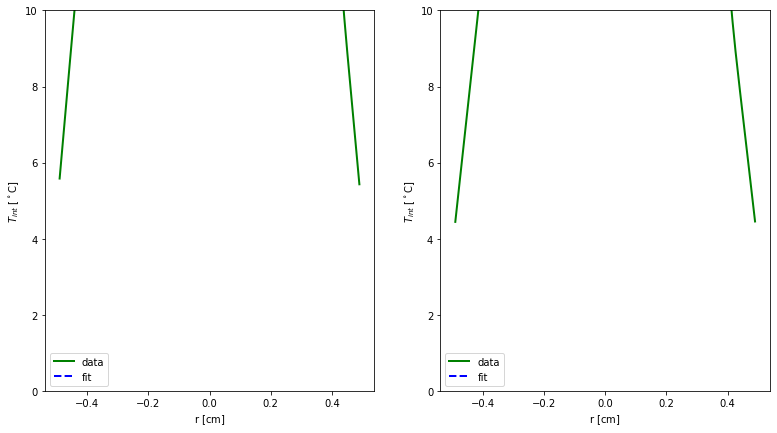

In [32]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, t_int_vals0,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_int0,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
fig1.set_ylim(0, 10)
fig1.legend()


fig2.plot(radpts_x, t_int_vals1,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_int1,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
fig2.set_ylim(0, 10)
fig2.legend()

fig.show()

printmd('$\hspace{13mm}$ $T_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_int0, fit_Bq_int0, fit_Aq_int1, fit_Bq_int1))

$\hspace{13mm}$ $T_{int} = -281.80990 r^2 + 35.05721$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = -198.23285 r^2 + 24.56722$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

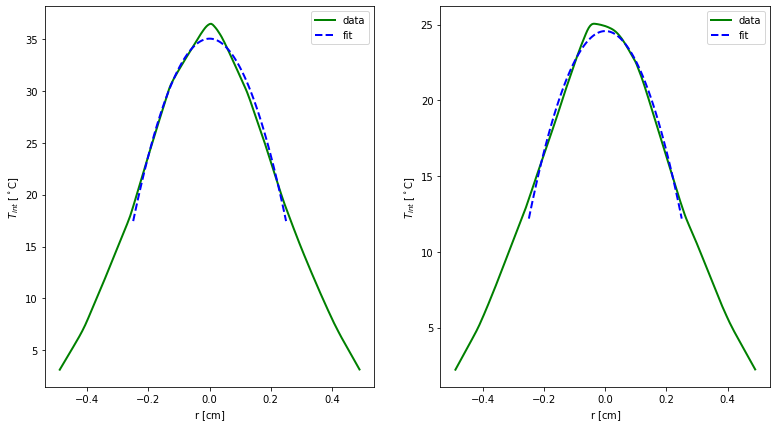

In [33]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, t_int_vals2,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_int2,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig1.set_ylim(0, 6)
fig1.legend()


fig2.plot(radpts_x, t_int_vals3,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_int3,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig2.set_ylim(0, 6)
fig2.legend()

fig.show()

printmd('$\hspace{13mm}$ $T_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_int2, fit_Bq_int2, fit_Aq_int3, fit_Bq_int3))

### Calculate index of refraction for each slice

In [34]:
#calculate n_int vals from t_int_vals
for j in range(n_uz):
    globals()['n_int_vals'+str(j)] = []
    for i in range(len(t_int_vals0)):
        globals()['n_int'+str(j)] = 1.75991 + (1.28e-5 * globals()['t_int_vals'+str(j)][i]) + (3.1e-9 * globals()['t_int_vals'+str(j)][i]**2)
        
        globals()['n_int_vals'+str(j)].append(globals()['n_int'+str(j)])

In [35]:
# create arrays for n_int(r) for region within laser radius
n_int_vals0_laser = n_int_vals0[laser_ran_min:laser_ran_max]
n_int_vals1_laser = n_int_vals1[laser_ran_min:laser_ran_max]
n_int_vals2_laser = n_int_vals2[laser_ran_min:laser_ran_max]
n_int_vals3_laser = n_int_vals3[laser_ran_min:laser_ran_max]
n_int_vals4_laser = n_int_vals4[laser_ran_min:laser_ran_max]
n_int_vals5_laser = n_int_vals5[laser_ran_min:laser_ran_max]
n_int_vals6_laser = n_int_vals6[laser_ran_min:laser_ran_max]
n_int_vals7_laser = n_int_vals7[laser_ran_min:laser_ran_max]

In [36]:
parameters_q_intn0, covariance_q_intn0 = curve_fit(quad_int0, radpts_x_laser, n_int_vals0_laser)
parameters_q_intn1, covariance_q_intn1 = curve_fit(quad_int0, radpts_x_laser, n_int_vals1_laser)
parameters_q_intn2, covariance_q_intn2 = curve_fit(quad_int0, radpts_x_laser, n_int_vals2_laser)
parameters_q_intn3, covariance_q_intn3 = curve_fit(quad_int0, radpts_x_laser, n_int_vals3_laser)
parameters_q_intn4, covariance_q_intn4 = curve_fit(quad_int0, radpts_x_laser, n_int_vals4_laser)
parameters_q_intn5, covariance_q_intn5 = curve_fit(quad_int0, radpts_x_laser, n_int_vals5_laser)
parameters_q_intn6, covariance_q_intn6 = curve_fit(quad_int0, radpts_x_laser, n_int_vals6_laser)
parameters_q_intn7, covariance_q_intn7 = curve_fit(quad_int0, radpts_x_laser, n_int_vals7_laser)
  
fit_Aq_intn0 = parameters_q_intn0[0]
fit_Bq_intn0 = parameters_q_intn0[1]
fit_Aq_intn1 = parameters_q_intn1[0]
fit_Bq_intn1 = parameters_q_intn1[1]
fit_Aq_intn2 = parameters_q_intn2[0]
fit_Bq_intn2 = parameters_q_intn2[1]
fit_Aq_intn3 = parameters_q_intn3[0]
fit_Bq_intn3 = parameters_q_intn3[1]
fit_Aq_intn4 = parameters_q_intn4[0]
fit_Bq_intn4 = parameters_q_intn4[1]
fit_Aq_intn5 = parameters_q_intn5[0]
fit_Bq_intn5 = parameters_q_intn5[1]
fit_Aq_intn6 = parameters_q_intn6[0]
fit_Bq_intn6 = parameters_q_intn6[1]
fit_Aq_intn7 = parameters_q_intn7[0]
fit_Bq_intn7 = parameters_q_intn7[1]

  
fit_yq_intn0 = quad_int0(radpts_x_laser, fit_Aq_intn0, fit_Bq_intn0)
fit_yq_intn1 = quad_int0(radpts_x_laser, fit_Aq_intn1, fit_Bq_intn1)
fit_yq_intn2 = quad_int0(radpts_x_laser, fit_Aq_intn2, fit_Bq_intn2)
fit_yq_intn3 = quad_int0(radpts_x_laser, fit_Aq_intn3, fit_Bq_intn3)
fit_yq_intn4 = quad_int0(radpts_x_laser, fit_Aq_intn4, fit_Bq_intn4)
fit_yq_intn5 = quad_int0(radpts_x_laser, fit_Aq_intn5, fit_Bq_intn5)
fit_yq_intn6 = quad_int0(radpts_x_laser, fit_Aq_intn6, fit_Bq_intn6)
fit_yq_intn7 = quad_int0(radpts_x_laser, fit_Aq_intn7, fit_Bq_intn7)

In [37]:
n2_vals = (fit_Aq_intn0, fit_Aq_intn1, fit_Aq_intn2, fit_Aq_intn3, fit_Aq_intn4, fit_Aq_intn5, fit_Aq_intn6, fit_Aq_intn7)
print(n2_vals)
n0_vals = (fit_Bq_intn0, fit_Bq_intn1, fit_Bq_intn2, fit_Bq_intn3, fit_Bq_intn4, fit_Bq_intn5, fit_Bq_intn6, fit_Bq_intn7)

(-0.007394861443015258, -0.005352281123319933, -0.0036558443957421787, -0.002561380442756301, -0.0017295306120014406, -0.001280528357647268, -0.0008173906666506236, -0.0005745639088384052)


$\hspace{13mm}$ $n_{int} = -0.00739 r^2 + 1.76077$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $n_{int} = -0.00535 r^2 + 1.76055$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

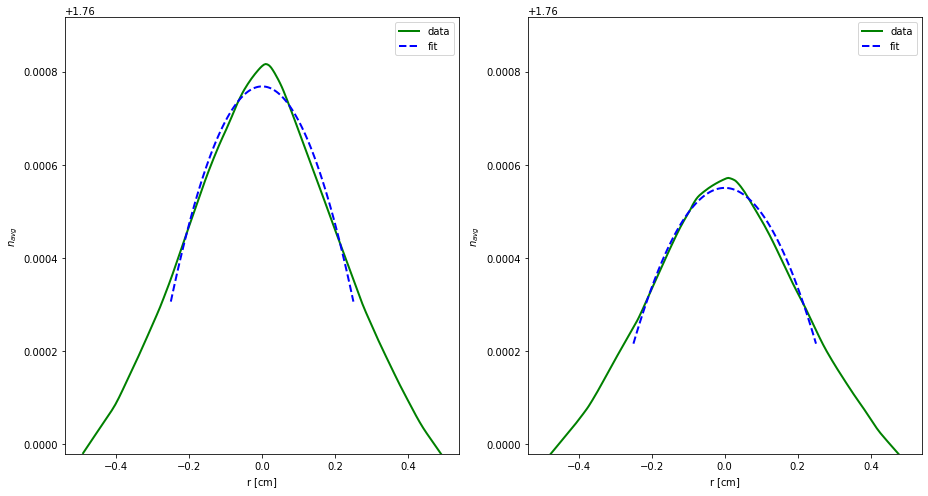

In [38]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, n_int_vals0,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_intn0,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$n_{avg}$')
fig1.set_ylim(np.min(n_int_vals0), np.max(n_int_vals0) + 1e-4)
fig1.legend()


fig2.plot(radpts_x, n_int_vals1,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_intn1,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$n_{avg}$')
fig2.set_ylim(np.min(n_int_vals0), np.max(n_int_vals0) + 1e-4)
# fig2.set_ylim(np.min(n_int_vals1), np.max(n_int_vals1))
fig2.legend()

fig.tight_layout()
fig.show()

printmd('$\hspace{13mm}$ $n_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $n_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_intn0, fit_Bq_intn0, fit_Aq_intn1, fit_Bq_intn1))

In [39]:
l_vals = []
n_int_max_vals = []
for j in range(n_uz):
    n_int_max_val = np.max(globals()['n_int_vals'+str(j)])
    n_int_max_vals.append(n_int_max_val)
    l_val = (leng/n_uz)*j + (0.5 * (leng/n_uz))
    l_vals.append(l_val)

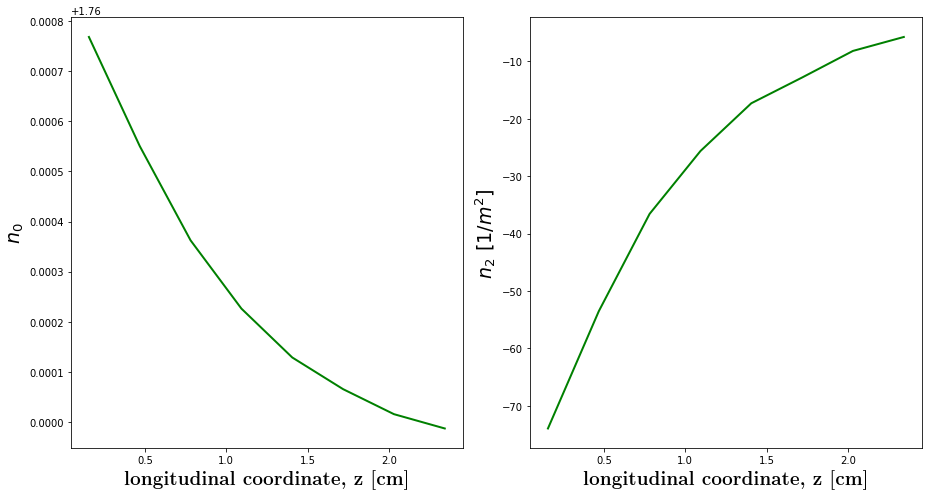

In [40]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(l_vals, n0_vals,'g-', linewidth = 2)
fig1.set_xlabel(r'longitudinal coordinate, z [cm]',**hfontMed)
fig1.set_ylabel(r'$n_0$',**hfontMed)
# fig1.set_ylim(0, 6)
# fig1.legend()

fig2.plot(l_vals, np.multiply(n2_vals, 1e4),'g-', linewidth = 2, label = 'data')
fig2.set_xlabel(r'longitudinal coordinate, z [cm]',**hfontMed)
fig2.set_ylabel(r'$n_2$ $[1/m^2]$',**hfontMed)
# fig2.set_ylim(0, 6)
# fig2.legend()

fig.tight_layout()
fig.show()

In [41]:
l_vals = []
n_int_max_vals = []
for j in range(n_uz):
    n_int_max_val = np.max(globals()['n_int_vals'+str(j)])
    n_int_max_vals.append(n_int_max_val)
    l_val = (leng/n_uz)*j + (0.5 * (leng/n_uz))
    l_vals.append(l_val)

In [42]:
print(n_int_max_vals)
print(l_vals)

[1.7608164081108308, 1.7605720048517646, 1.760381239202798, 1.76023257055833, 1.7601390673932127, 1.7600692927120287, 1.7600184289591037, 1.7599901288738924]
[0.15625, 0.46875, 0.78125, 1.09375, 1.40625, 1.71875, 2.03125, 2.34375]


#### Innocenzi benchmarking
"Thermal modeling of continuous-wave end-pumped solid-state lasers"

Innocenzi 1990

In [43]:
from scipy.special import exp1
print(np.shape(zv))
print(np.shape(radpts_x))

(201,)
(201,)


In [44]:
print(np.min(zv))
print(np.max(zv))

-1.225
1.225


In [45]:
print('Power input: %s [W]' %P_abs)      # absorbed power [W]
print('alpha: %.2f [1/cm]' %(alpha_h))    # absorption coefficient [1/cm]
print('laser radius: %s [cm]' %wdT)        # laser radius [cm]
   
r_b = 0.75                # radius to crystal boundary, r_max [cm]


K_c = K_c_ndyag

print('thermal conductivity: %s [W/cm/K]' %K_c)

Power input: 6.7 [W]
alpha: 1.20 [1/cm]
laser radius: 0.162 [cm]
thermal conductivity: 0.1 [W/cm/K]


In [46]:
# dT_innocenzi_r0 = (alpha_h * P_abs) * np.exp(-alpha_h * zv) / (4 * np.pi * K_c) \
#      * (np.log(np.square(r_b / radpts_x)) + exp1(2 * r_b**2 / wdT) - exp1(2 * np.square(radpts_x / wdT)))

In [47]:
# Following expressions match with K_c = 33
# # Innocenzi dT at crystal entrance (z = 0.0 cm)
# dT_innocenzi_re = 1.7 * 1.05 * (alpha_h * P_abs) * np.exp(-alpha_h * 0.0) / (4 * np.pi * K_c) \
#      * (np.log(np.square(r_b / radpts_x)) + exp1(2 * r_b**2 / (wdT*1.7)) - exp1(2 * np.square(radpts_x / (wdT*1.7))))
# # Innocenzi dT at crystal center (z = 0.5 cm)
# dT_innocenzi_r0 = 1.7 * 1.55 * (alpha_h * P_abs) * np.exp(-alpha_h * 0.5) / (4 * np.pi * K_c) \
#      * (np.log(np.square(r_b / radpts_x)) + exp1(2 * r_b**2 / (wdT*1.7)) - exp1(2 * np.square(radpts_x / (wdT*1.7))))
# # Innocenzi dT at crystal exit (z = 1.0 cm)
# dT_innocenzi_rx = 1.7 * 2.2 * (alpha_h * P_abs) * np.exp(-alpha_h * 1.0) / (4 * np.pi * K_c) \
#      * (np.log(np.square(r_b / radpts_x)) + exp1(2 * r_b**2 / (wdT*1.7)) - exp1(2 * np.square(radpts_x / (wdT*1.7))))

In [48]:
# # Innocenzi dT at crystal entrance (z = 0.0 cm)
# dT_innocenzi_re = (alpha_h * P_abs) * np.exp(-alpha_h * 0.0) / (4 * np.pi * K_c) \
#      * (np.log(np.square(r_b / radpts_x)) + exp1(2 * r_b**2 / (wdT*1.7)) - exp1(2 * np.square(radpts_x / (wdT*1.7))))
# # Innocenzi dT at crystal center (z = 0.5 cm)
# dT_innocenzi_r0 = 1.5 * 1.0 * (alpha_h * P_abs) * np.exp(-alpha_h * 0.5) / (4 * np.pi * K_c) \
#      * (np.log(np.square(r_b / radpts_x)) + exp1(2 * r_b**2 / (wdT*1.7)) - exp1(2 * np.square(radpts_x / (wdT*1.7))))
# # Innocenzi dT at crystal exit (z = 1.0 cm)
# dT_innocenzi_rx = 1.7 * 2.2 * (alpha_h * P_abs) * np.exp(-alpha_h * 1.0) / (4 * np.pi * K_c) \
#      * (np.log(np.square(r_b / radpts_x)) + exp1(2 * r_b**2 / (wdT*1.7)) - exp1(2 * np.square(radpts_x / (wdT*1.7))))

In [49]:
# radpts_x = np.asarray([x for x in xv if x != 0])

In [50]:
# Innocenzi dT at crystal entrance (z = 0.0 cm)
dT_innocenzi_re = (alpha_h * P_abs) * np.exp(-alpha_h * (0.0)) / (4 * np.pi * K_c) \
     * (np.log(np.square(r_b / radpts_x)) + exp1(2 * np.square(r_b / wdT)) - exp1(2 * np.square(radpts_x / (wdT))))
# Innocenzi dT at crystal center (z = 1.25 cm)
dT_innocenzi_r0 = (alpha_h * P_abs) * np.exp(-alpha_h * 1.25) / (4 * np.pi * K_c) \
     * (np.log(np.square(r_b / radpts_x)) + exp1(2 * np.square(r_b / wdT)) - exp1(2 * np.square(radpts_x / (wdT))))
# Innocenzi dT at crystal exit (z = 2.5 cm)
dT_innocenzi_rx = (alpha_h * P_abs) * np.exp(-alpha_h * 2.5) / (4 * np.pi * K_c) \
     * (np.log(np.square(r_b / radpts_x)) + exp1(2 * np.square(r_b / wdT)) - exp1(2 * np.square(radpts_x / (wdT))))

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:

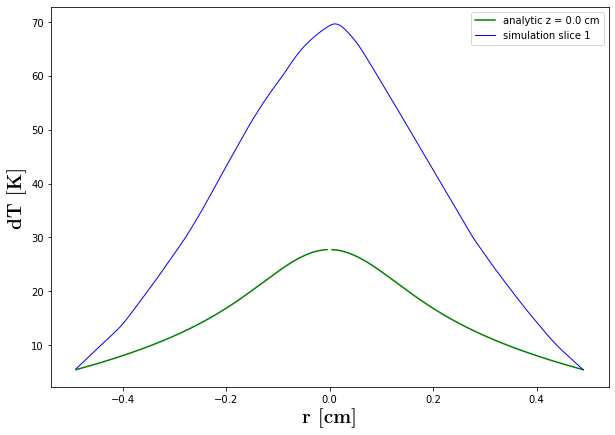

In [51]:
# match analytic/simulation at crystal entrance
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(radpts_x, dT_innocenzi_re, 'g-', label = 'analytic z = 0.0 cm')
# ax.plot(radpts_x, t_int_vals2,'k-', linewidth = 1, label = 'simulation slice 3')
ax.plot(radpts_x, t_int_vals0,'b-', linewidth = 1, label = 'simulation slice 1')
# ax.plot(radpts_x, t_int_vals4,'r-', linewidth = 1, label = 'simulation slice 5')
ax.set_ylabel(r'dT [K]',**hfontMed)
ax.set_xlabel(r'r [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
ax.legend()
plt.show()

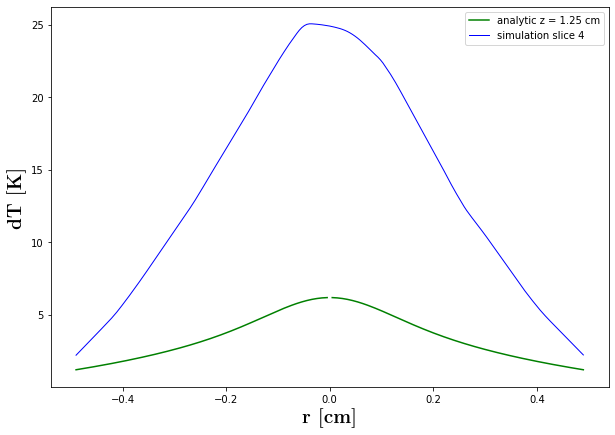

In [52]:
# match analytic/simulation at crystal center
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(radpts_x, dT_innocenzi_r0, 'g-', label = 'analytic z = 1.25 cm')
# ax.plot(radpts_x, t_int_vals2,'k-', linewidth = 1, label = 'simulation slice 3')
ax.plot(radpts_x, t_int_vals3,'b-', linewidth = 1, label = 'simulation slice 4')
# ax.plot(radpts_x, t_int_vals4,'r-', linewidth = 1, label = 'simulation slice 5')
ax.set_ylabel(r'dT [K]',**hfontMed)
ax.set_xlabel(r'r [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
ax.legend()
plt.show()

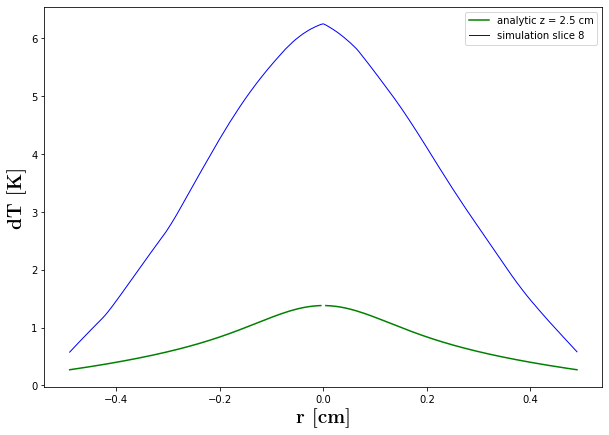

In [53]:
# match analytic/simulation at crystal end
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(radpts_x, dT_innocenzi_rx, 'g-', label = 'analytic z = 2.5 cm')
# ax.plot(radpts_x, t_int_vals2,'k-', linewidth = 1, label = 'simulation slice 3')
ax.plot(radpts_x, t_int_vals7,'b-', linewidth = 1, label = 'simulation slice 8')
# ax.plot(radpts_x, t_int_vals4,'r-', linewidth = 1, label = 'simulation slice 5')
ax.set_ylabel(r'dT [K]',**hfontMed)
ax.set_xlabel(r'r [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
ax.legend()
plt.show()

#### Gaussian power distribution analysis
<img src="figures/pow_dist_gsn01.png">

In [ ]:
Expression('dT * exp( -(pow(((x[0]*x[0] - b1) / c1), 2) + (pow(((x[1]*x[1] - b1) / c1), 2) ))) * (exp(-alpha_h * x[2]))', 
           degree = 1, dT = dT_incr, b1 = b1, c1 = c1, alpha_h = alpha_h)

In [ ]:
dT_incr

In [ ]:
# choose a longitudinal position to examine power distribution [cm]
z_power_dist = 0.0
z_power_dist02 = 0.5
z_power_dist03 = 1.0

# potentially slightly different because r = sqrt(x^2 + y^2)
temp_dist_gsn = dT_incr * np.exp(-np.square((radpts_x**2 - b1) / c1)) * np.exp(-alpha_h * z_power_dist) 

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(radpts_x, temp_dist_gsn, 'g-')
# ax.plot(radpts_x, t_int_vals2,'k-', linewidth = 1, label = 'simulation slice 3')
# ax.plot(radpts_x, t_int_vals3,'b-', linewidth = 1, label = 'simulation slice 4')
# ax.plot(radpts_x, t_int_vals4,'r-', linewidth = 1, label = 'simulation slice 5')
ax.set_ylabel(r'T [K]',**hfontMed)
ax.set_xlabel(r'r [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
# ax.legend()
plt.show()

In [ ]:
# # Calculate absorbed power distribution following these substitutions:

# dT_incr = dQ_incr / rho / c_p

# dQ_incr = P_abs / V_abs

# dT_incr = P_abs / V_abs / rho / c_p  -->  dT_incr = (P_abs / (V_abs * rho * c_p))

# temp_dist_gsn = dT_incr * np.exp(-np.square((radpts_x**2 - b1) / c1)) * np.exp(-alpha_h * z_power_dist) 

# P_abs = temp_dist_gsn * V_abs * rho * c_p

# --> P_abs = V_abs * rho * c_p * dT_incr * np.exp(-np.square((radpts_x**2 - b1) / c1)) * np.exp(-alpha_h * z_power_dist)


In [ ]:
P_abs_dist_gsn = V_abs * rho * c_p * dT_incr * np.exp(-np.square((radpts_x**2 - b1) / c1)) * np.exp(-alpha_h * z_power_dist)
P_abs_dist_gsn02 = V_abs * rho * c_p * dT_incr * np.exp(-np.square((radpts_x**2 - b1) / c1)) * np.exp(-alpha_h * z_power_dist02)
P_abs_dist_gsn03 = V_abs * rho * c_p * dT_incr * np.exp(-np.square((radpts_x**2 - b1) / c1)) * np.exp(-alpha_h * z_power_dist03)

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(radpts_x, P_abs_dist_gsn, 'g-', label = "z = 0.0 cm")
ax.plot(radpts_x, P_abs_dist_gsn02, 'r-', label = "z = 0.5 cm")
ax.plot(radpts_x, P_abs_dist_gsn03, 'b-', label = "z = 1.0 cm")
# ax.plot(radpts_x, t_int_vals2,'k-', linewidth = 1, label = 'simulation slice 3')
# ax.plot(radpts_x, t_int_vals3,'b-', linewidth = 1, label = 'simulation slice 4')
# ax.plot(radpts_x, t_int_vals4,'r-', linewidth = 1, label = 'simulation slice 5')
ax.set_ylabel(r'P [W]',**hfontMed)
ax.set_xlabel(r'r [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
ax.legend()
plt.show()